In [ ]:
import cv2
import numpy as np
from PIL import Image
import math


: 

In [58]:

def get_size(img):
    (h, w) = img.shape[:2]
    ratio=w/h
    return h,w,ratio

def resize_if_big(img,width_limit=1000):
    (h, w) = img.shape[:2]
    ratio=w/h

    if w > 1000:    
        new_w = width_limit
        new_h = int(new_w/ratio)    
        img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
        
    return img

def cv_to_gray(img):
    #RGB To Gray Scale
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  
    return gray

def cv_to_negative(img):
    # and flip the foreground and background to ensure foreground is now "white" and the background is "black"
    negative = cv2.bitwise_not(img)
    return negative

def cv_to_blur(img,kernel=(5, 5)): 
    #(5,5) is the kernel size and 0 is sigma that determines the amount of blur
    blur=cv2.GaussianBlur(img,kernel,0)  
    return blur

def cv_to_edge(img,min=30,max=50):
    # Edge detection
    #30 MinThreshold and 50 is the MaxThreshold
    edge=cv2.Canny(img,min,max)  
    return edge

def cv_to_thick(img,kernel=np.ones((8, 8))):    
    #  DILATION
    dilated = cv2.dilate(img, kernel, iterations=2) 
    return dilated

def cv_to_slim(img,kernel=np.ones((8, 8))):    
    #  EROSION
    eroded = cv2.erode(img, kernel, iterations=1) 
    return eroded

def cv_to_binary(img,min=0,max=255)):    
    # threshold the image, setting all foreground pixels to
    # 255 and all background pixels to 0
    thresh = cv2.threshold(img, min,max,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    return thresh

def cv_to_adaptive_treshold(img,max=255,neigh_size=21,c=10):    
    # instead of manually specifying the threshold value, we can use
    # adaptive thresholding to examine neighborhoods of pixels and
    # adaptively threshold each neighborhood
    thresh = cv2.adaptiveThreshold(img, max,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, neigh_size, c)
    return thresh

def get_notnull_coords(bin_img):
    # grab the (x, y) coordinates of all pixel values that are greater than zero, 
    coords = np.column_stack(np.where(bin_img > 0))
    return coords

def get_contours(img):
    # FIND ALL CONTOURS
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
    return contours

def find_biggest_contour(contours):
    # FIND THE BIGGEST CONTOUR
    #retrieve the contours as a list, with simple apprximation model
    contours=sorted(contours,key=cv2.contourArea,reverse=True)

    #the loop extracts the boundary contours of the page
    for c in contours:
        p=cv2.arcLength(c,True)
        approx=cv2.approxPolyDP(c,0.02*p,True)

        if len(approx)==4:
            biggest=approx
            break
    return biggest
    # biggest = np.array([])
    # max_area = 0
    # for i in contours:
    #     area = cv2.contourArea(i)
    #     if area > 5000:
    #         peri = cv2.arcLength(i, True)
    #         approx = cv2.approxPolyDP(i, 0.02 * peri, True)
    #         if area > max_area and len(approx) == 4:
    #             biggest = approx
    #             max_area = area
    # return biggest, max_area

def find_corners(cnt):
    cnt = cnt.reshape((4,2))
    hnew = np.zeros((4,2),dtype = np.float32)

    add = cnt.sum(1)
    hnew[0] = cnt[np.argmin(add)]
    hnew[2] = cnt[np.argmax(add)]

    diff = np.diff(cnt,axis = 1)
    hnew[1] = cnt[np.argmin(diff)]
    hnew[3] = cnt[np.argmax(diff)]

    return hnew

def cv_to_unwarp(start_img,corners,window=800):
    #map to 800*800 target window
    pts=np.float32([[0,0],[window,0],[window,window],[0,window]])  

    #get the top or bird eye view effect
    op=cv2.getPerspectiveTransform(corners,pts)  
    final=cv2.warpPerspective(start_img,op,(window,window))
    return final

def draw_contours(img,contours,colour=(0, 255, 0),size=5):
    # DRAW ALL DETECTED CONTOURS
    img2 = img.copy() 
    # -1 signifies drawing all contours
    cv2.drawContours(img2, contours, -1, colour, size)
    return img2

def get_angle_from_cnt(cnt):
    # ompute a rotated bounding box that contains all coordinates
    rect = cv2.minAreaRect(cnt)
    angle = rect[-1]

    # the `cv2.minAreaRect` function returns values in the range [-90, 0]
    # as the rectangle rotates clockwise the returned angle trends to 0 - in this special case weneed to add 90 degrees 
    if angle < -45:
        angle = -(90 + angle)
    else:
        # otherwise, just take the inverse of the angle to makeit positive
        angle = -angle
    
    return rect,angle

def draw_rect(img,rect,show_angle=True,colour=(36,255,12),size=3):
    img2 = img.copy() 
    if show_angle:
        # draw the correction angle on the image so we can validate it
        cv2.putText(img2, f"Angle: {angle}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # cv2.rectangle(img2,tl,br,(0,255,0),3)

    box = np.intp(cv2.boxPoints(rect))
    cv2.drawContours(img2, [box], 0, colour, size)
    return img2

def cv_deskew(img,angle):
    # rotate the image to deskew it
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def get_lines_data(bin_img,max=220):
    # Hough transform -  to find straight LINES in it
    lines = cv2.HoughLines(bin_img, 1, np.pi / 180, max)
    lines_data=[]

    for line in lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        # x1 stores the rounded off value of (r * cos(theta) - 1000 * sin(theta))
        x1 = int(x0 + 1000 * (-b))
        # y1 stores the rounded off value of (r * sin(theta)+ 1000 * cos(theta))
        y1 = int(y0 + 1000 * (a))
        # x2 stores the rounded off value of (r * cos(theta)+ 1000 * sin(theta))
        x2 = int(x0 - 1000 * (-b))
        # y2 stores the rounded off value of (r * sin(theta)- 1000 * cos(theta))
        y2 = int(y0 - 1000 * (a))

        angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
        lines_data.append(((x1, y1), (x2, y2), angle))    
    return lines_data

def get_lines_data_p(bin_img):
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 15  # min number of votes (intersections in Hough grid cell)
    min_line_length = 600  # min number of pixels making up a line
    max_line_gap = 20  # max gap in pixels between connectable line segments

    # %%  Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments

    lines = cv2.HoughLinesP(bin_img, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    if lines is not None:
        lines_data=[]
        for line in lines:
            for x1, y1, x2, y2 in line:    
                angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
                lines_data.append(((x1, y1), (x2, y2), angle))
    return lines_data

def most_frequent_angle(lines_data):
    # TODO
    return lines_data


def draw_lines(img,lines_data, colour=(0,0,255),size=2):
    img2 = img.copy() 
 
    for line in lines_data:
        p1,p2,angle=line
        #draw line
        cv2.line(img2, p1, p2, colour, size)

    return img2

def cv_export_file(img,path,fname):
    return cv2.imwrite(path + f"{fname}.jpg",img)

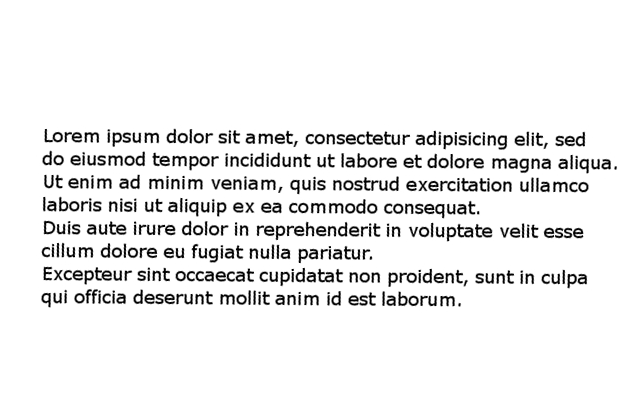

In [54]:
#read in the image
bin_img=cv2.imread("sam3.jpg")
base=bin_img.copy()

bin_img=resize_if_big(bin_img)

bin_img=cv_to_blur(bin_img)
Image.fromarray(bin_img)

bin_img=cv_to_gray(bin_img)
Image.fromarray(bin_img)

bin_img=cv_to_edge(bin_img)
Image.fromarray(bin_img)

bin_img=cv_to_thick(bin_img)
Image.fromarray(bin_img)

# img=cv_to_slim(img)
# Image.fromarray(img)

cnt=get_contours(bin_img)[0]

bin_img=draw_contours(bin_img,cnt)
Image.fromarray(bin_img)

rect,angle=get_angle_from_cnt(cnt)

bin_img=draw_rect(bin_img,rect)
Image.fromarray(bin_img)

bin_img=cv_deskew(base,-angle)
Image.fromarray(bin_img)

# ld=cv_to_lines(cv_to_edge(base))
# img=draw_lines(base,ld)
# Image.fromarray(img)


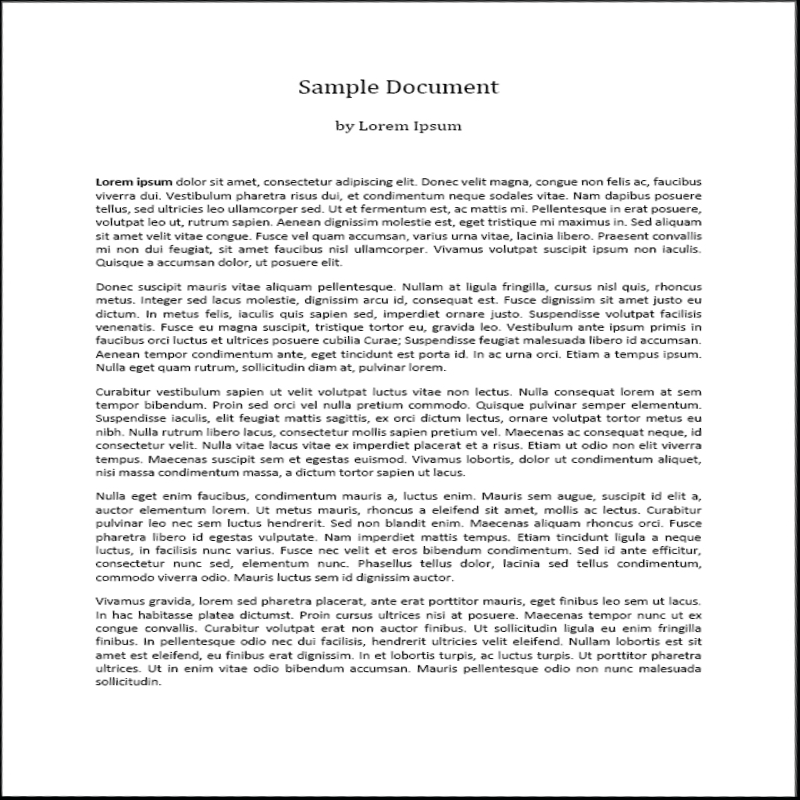

In [59]:
# UNWARP
#read in the image
img=cv2.imread("sam1.jpg")
base=img.copy()

img=resize_if_big(img)

img=cv_to_blur(img)
Image.fromarray(img)

img=cv_to_gray(img)
Image.fromarray(img)

img=cv_to_edge(img)
Image.fromarray(img)

img=cv_to_thick(img)
Image.fromarray(img)

img=cv_to_slim(img)
Image.fromarray(img)

cnts=get_contours(img)
cnt=find_biggest_contour(cnts)

img=draw_contours(img,cnt)
Image.fromarray(img)

corners=find_corners(cnt)
img=cv_to_unwarp(base,corners)
Image.fromarray(img)


In [5]:
#read in the image
image=cv2.imread("sam3.jpg")   
(cnt, w) = image.shape[:2]
ratio=cnt/w
TARGET_H=800
# resizing because opencv does not work well with bigger images
image=cv2.resize(image,(TARGET_H,int(TARGET_H*ratio))) 
base=image.copy()

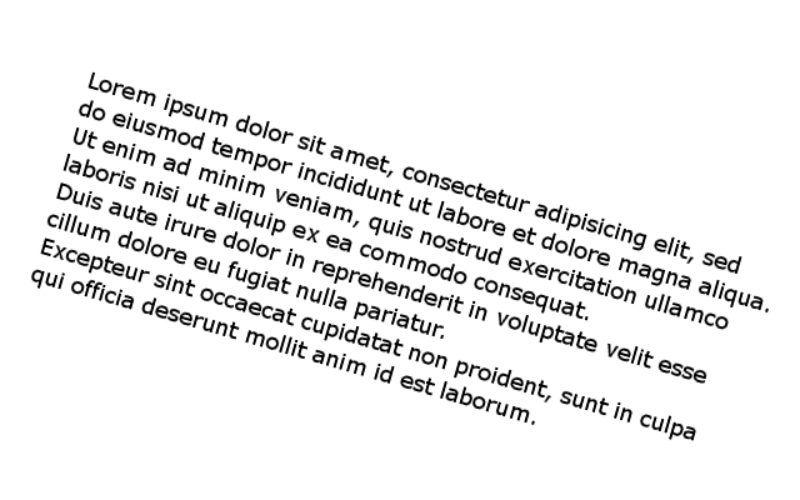

In [6]:
#RGB To Gray Scale
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)  
# cv2.imshow("Title",gray)
Image.fromarray(gray)

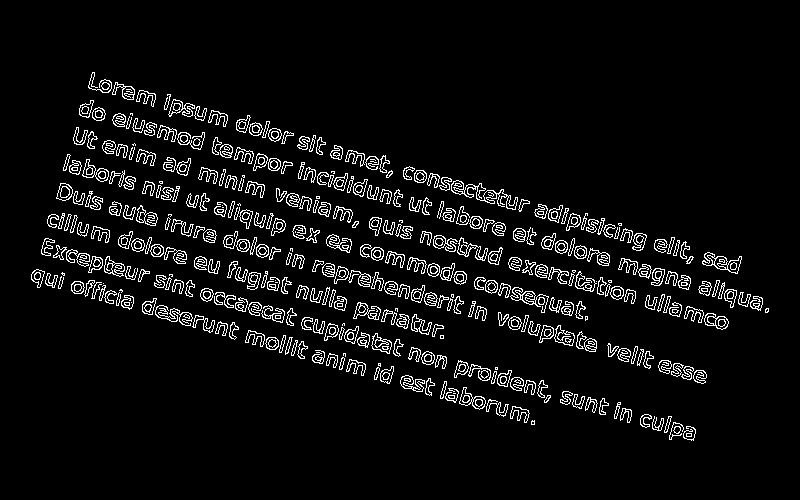

In [7]:
# Edge detection
#30 MinThreshold and 50 is the MaxThreshold
edge=cv2.Canny(gray,30,50)  
Image.fromarray(edge)


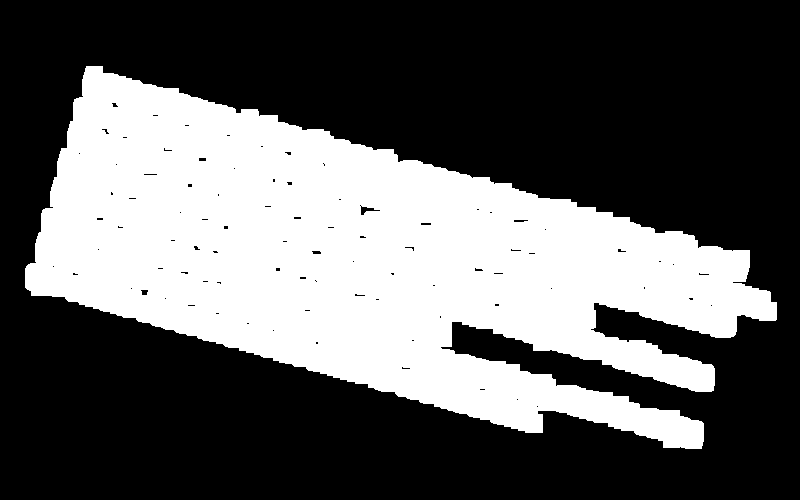

In [8]:
kernel = np.ones((8, 8))
# APPLY DILATION
dilated = cv2.dilate(edge, kernel, iterations=2) 
Image.fromarray(dilated)


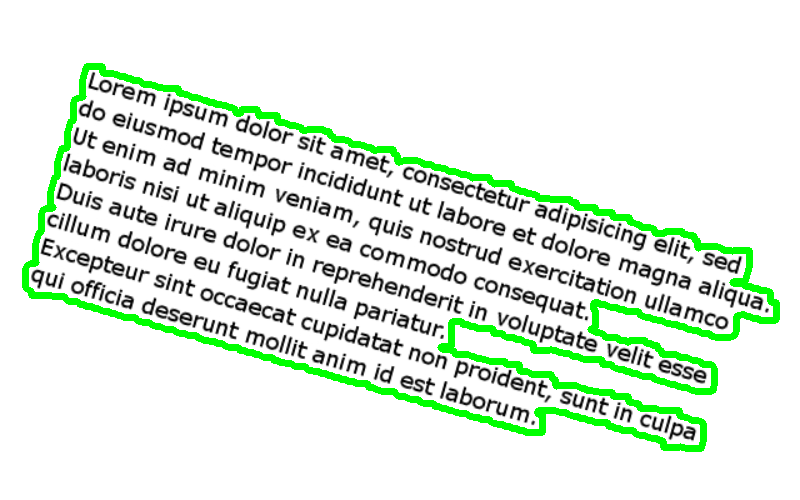

In [9]:
# FIND ALL CONTOURS
contours, hierarchy = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
# DRAW ALL DETECTED CONTOURS
imgContours = base.copy() 
# -1 signifies drawing all contours
cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 5) 
Image.fromarray(imgContours)

In [10]:
# then use these coordinates to compute a rotated bounding box that contains all coordinates
rect = cv2.minAreaRect(contours[0])
angle = rect[-1]

# the `cv2.minAreaRect` function returns values in the range [-90, 0]
# as the rectangle rotates clockwise the returned angle trends to 0 - in this special case weneed to add 90 degrees 
if angle < -45:
	angle = -(90 + angle)
else:
	# otherwise, just take the inverse of the angle to makeit positive
	angle = -angle

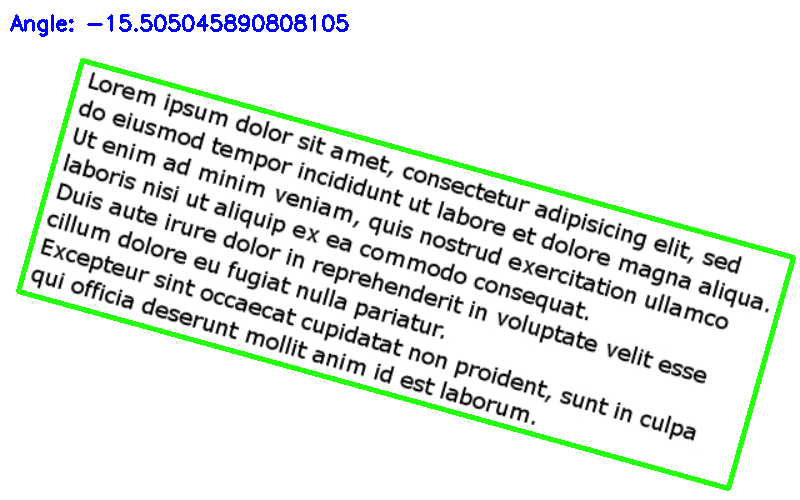

In [11]:
imgRectangle = base.copy() 

# draw the correction angle on the image so we can validate it
cv2.putText(imgRectangle, f"Angle: {angle}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

# cv2.rectangle(imgRectangle,tl,br,(0,255,0),3)
box = np.intp(cv2.boxPoints(rect))
cv2.drawContours(imgRectangle, [box], 0, (36,255,12), 3)

Image.fromarray(imgRectangle)

In [17]:

# rotate the image to deskew it
(cnt, w) = image.shape[:2]
center = (w // 2, cnt // 2)

M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(image, M, (w, cnt), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

[INFO] angle: -15.505


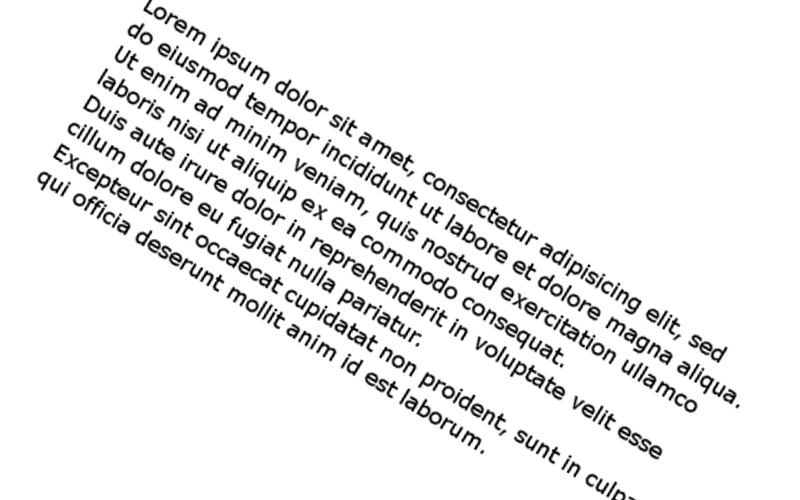

In [18]:
# show the output image
print("[INFO] angle: {:.3f}".format(angle))
Image.fromarray(rotated)